In [176]:
import pandas as pd
import NewsSocialSignaling
import os
import pickle
import numpy as np
import tqdm
import ResearchTools
from IPython.display import Image
import implicit
from scipy import sparse
import statsmodels.formula.api as smf

## Read data

In [177]:
twitter_path = 'C:/Users/moehring/Dropbox (Personal)/Projects/NewsSocialSignaling/data/raw/newspaper_quality'
fn = os.path.join(twitter_path, 'newspaper_quality_processed_all_pubs.txt')

pubs = pd.read_table(fn, sep='\t')
pubs.single_twitter_handle = pubs.single_twitter_handle.apply(lambda v: v.lower())
print(pubs.head())

# filter a few
pubs = pubs.loc[pubs.single_twitter_handle != 'barackobama']

     canonical  twitter_id  hardScoreSum  numHardArticles  numArticles  \
0   10best.com  17389704.0   4353.245115             2277        19437   
1   10news.com   9616062.0   5037.951620             5430         7965   
2     10tv.com  15304100.0   2824.105864             2924         3938   
3  11alive.com  14268564.0   6121.475973             6048         9885   
4   12news.com  17187236.0   4835.549924             4535         8963   

    domain single_twitter_handle  num_followers  hard_score  hard_score_old  \
0   10best                10best        15398.0    0.117148        0.223967   
1   10news                10news       176243.0    0.681733        0.632511   
2     10tv                  10tv       330563.0    0.742509        0.717142   
3  11alive           11alivenews       398314.0    0.611836        0.619269   
4   12news                12news       218352.0    0.505969        0.539501   

   score  rounded_n_shares  rounded_n_accts     slant  hard_score_quantile  \
0 

In [178]:
# load random sample
sample_name = 'random_sample_2013'

tmp_fn = 'C:/users/moehring/Downloads/tmp_twitters.p'
if True and os.path.exists(tmp_fn):
    with open(tmp_fn, 'rb') as f:
        existing_users = pickle.load(f)
else:
    existing_users = [el for el in NewsSocialSignaling.Database.get_all_users()
                      if isinstance(el['extra_data'], dict)
                      and 'sample_name' in el['extra_data']
                      and el['extra_data']['sample_name'] == sample_name
                      and not el['most_recent'].protected
                      ]
    with open(tmp_fn, 'wb') as f:
        pickle.dump(existing_users, f)

## Process / clean data

In [179]:
# ingest into user / publisher matrix
wide_df = pd.DataFrame(np.nan, index=[el['id'] for el in existing_users], columns=pubs.single_twitter_handle)
long_df = pd.DataFrame(columns=['pubid', 'follow', 'user'])
pubid2twitter = dict((row[1]['twitter_id'], row[1]['single_twitter_handle']) for row in pubs.iterrows())
for user in tqdm.tqdm(existing_users):
    friends = user['most_recent_friends']
    pub_friends = [el for el in friends if el in pubid2twitter]
    for p in pub_friends:
        row_ix = len(long_df)
        long_df.loc[row_ix, 'pubid'] = pubid2twitter[p]
        long_df.loc[row_ix, 'follow'] = 1
        long_df.loc[row_ix, 'user'] = user['id']
        wide_df.loc[user['id'], pubid2twitter[p]] = 1
long_df.follow = long_df.follow.astype(float)
long_df.pubid = long_df.pubid.astype('category')
long_df.user = long_df.user.astype('category')
print(long_df.head())
df = long_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11075/11075 [00:03<00:00, 2828.83it/s]

       pubid  follow   user
0   telegram     1.0  60453
1         f1     1.0  60453
2  foxsports     1.0  60453
3       uefa     1.0  60453
4        mls     1.0  60453


## Summaries

875/1645 publishers have 0 followers in our dataset


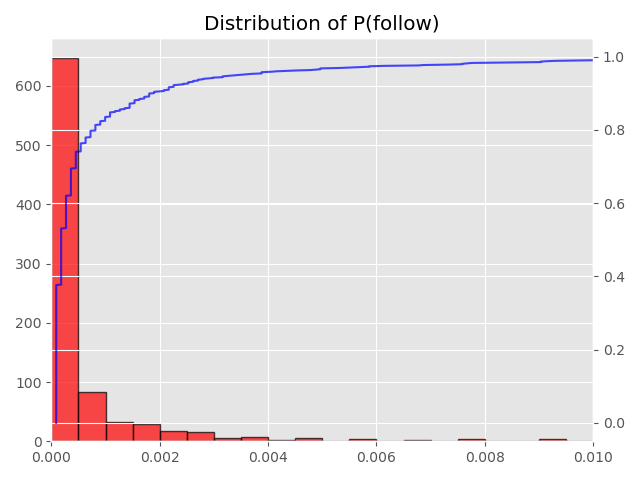

In [180]:
# first plot distribution of who follows who
pub_shares = wide_df.fillna(0).mean()
print('{0}/{1} publishers have 0 followers in our dataset'.format((pub_shares > 0).sum(), len(pub_shares)))

ResearchTools.ChartTools.plot_histogram_with_cdf(
    series=pub_shares[pub_shares > 0],
    pickle_fig=False,
    fn='./temp/tmp.png',
    show_graph=False,
    name='Distribution of P(follow)',
    rng=(0,0.01),
    xlabel='',
    nbins=20
)
Image(filename=('./temp/tmp.png'))

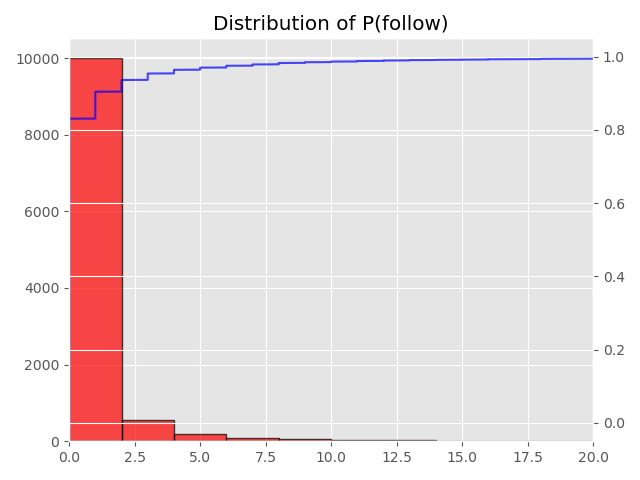

In [181]:
# first plot distribution of who follows who
user_num_pubs = wide_df.fillna(0).sum(axis=1)

ResearchTools.ChartTools.plot_histogram_with_cdf(
    series=user_num_pubs,
    pickle_fig=False,
    fn='./temp/tmp.png',
    show_graph=False,
    name='Distribution of P(follow)',
    rng=(0,20),
    xlabel='',
    nbins=10
)
Image(filename=('./temp/tmp.png'))

## Train implicit feedback collaborative filtering

In [182]:
# form train / test sets
rnd = np.random.RandomState(seed=809034)
train_share = 0.8
train_ids = rnd.choice(df.index, size=int(len(df) * train_share), replace=False)
train = df.loc[df.index.isin(train_ids)]
test = df.loc[~df.index.isin(train_ids)]
print('Train N: {0}; Test N: {1}'.format(len(train), len(test)))

Train N: 6196; Test N: 1550


In [183]:
sparse_df = sparse.coo_matrix((train.follow,
                               (train.pubid.cat.codes,
                                train.user.cat.codes)))
print(sparse_df.shape)
print(long_df.shape)

(875, 1876)
(7746, 3)


In [184]:
model = implicit.als.AlternatingLeastSquares(factors=20)
model.fit(sparse_df)

  0%|          | 0/15 [00:00<?, ?it/s]

In [185]:
users = long_df.user.unique()
print(long_df.head())
user_follows = sparse_df.T.tocsr()
recs = {}
for ix, uid in tqdm.tqdm(enumerate(users)):
    user_recs = model.recommend(ix, user_follows)
    recs[uid] = user_recs

       pubid  follow   user
0   telegram     1.0  60453
1         f1     1.0  60453
2  foxsports     1.0  60453
3       uefa     1.0  60453
4        mls     1.0  60453


1876it [00:00, 7173.03it/s]


In [186]:
pubs = ['nytimes', 'wsj', 'oann', 'huffpost', 'newsobserver']
pub2pubcat = dict((el, ix) for ix, el in enumerate(long_df.pubid.cat.categories))
pubcat2pub = dict((pub2pubcat[el], el) for el in pub2pubcat)
for p in pubs:
    pid = pub2pubcat[p]
    related = model.similar_items(pid)
    related = [(pubcat2pub[el[0]], el[1]) for el in related]
    print(related)

[('nytimes', 1.0), ('mcall', 0.9197739), ('indystar', 0.9158319), ('fox59', 0.9158318), ('wthrcom', 0.9151375), ('lancasteronline', 0.9069477), ('sportslogosnet', 0.79920846), ('kdvr', 0.7248029), ('blackamericaweb', 0.6681534), ('pcmag', 0.62781733)]
[('wsj', 0.9999999), ('inquirerdotnet', 0.8802379), ('repherald', 0.7669974), ('readingeagle', 0.7669974), ('weeklystandard', 0.7346485), ('mediaite', 0.63762116), ('spikedonline', 0.6241775), ('komonews', 0.62410814), ('enquirer', 0.6168904), ('kysportsradio', 0.6159776)]
[('oann', 0.99999994), ('newsmax', 0.98667717), ('townhallcom', 0.9762006), ('chicksonright', 0.9761447), ('marksteynonline', 0.9761447), ('breitbartnews', 0.9671147), ('anncoulter', 0.96493435), ('realdailywire', 0.9510836), ('bizpacreview', 0.94959134), ('77wabcradio', 0.94959134)]
[('huffpost', 1.0000001), ('fodorstravel', 0.85412186), ('pressenterprise', 0.84645534), ('freepress', 0.83702934), ('screencrushnews', 0.83702934), ('androidauth', 0.7629876), ('messengerp

## Evaluate recommendations

In [187]:
user2usercat = dict((el, ix) for ix, el in enumerate(long_df.user.cat.categories))
usercat2user = dict((ix, el) for ix, el in enumerate(long_df.user.cat.categories))

In [190]:
test_agg = pd.DataFrame(columns=['user', 'num_recommended', 'num_follow'])
num_recs = 10
popular_pubs = train.pubid.astype(str).value_counts()
for user, tmp in tqdm.tqdm(test.groupby('user')):
    # get history
    tmp_train = train.loc[train.user == user]
    if len(tmp_train) == 0 or len(tmp) == 0:
        # how to evaluate these?
        continue
    # get recommendations
    model_recs = model.recommend(user2usercat[user], user_follows, N=num_recs, filter_already_liked_items=True)
    model_recs = [pubcat2pub[el[0]] for el in model_recs]
    naive_recs = popular_pubs[~popular_pubs.index.isin(tmp_train.pubid)].index[0:5].tolist()
    #     print(naive_recs)
    #     print(model_recs)
    #     print(tmp_train.pubid.tolist())
#     print('\n\n')
#     print(tmp.pubid.tolist())
    for rec_name, recs in [('naive', naive_recs), ('collaborative_filter', model_recs)]:
#         print(recs)
        row_ix = len(test_agg)
        test_agg.loc[row_ix, 'algorithm'] = rec_name
        test_agg.loc[row_ix, 'user'] = user
        test_agg.loc[row_ix, 'num_recommended'] = tmp.pubid.isin(recs).sum()
        test_agg.loc[row_ix, 'num_follow'] = len(tmp)
    #     print(tmp_train)
    #     print(tmp)
    #     print(recs)
    #     print(test_agg.loc[row_ix])
    #     print('\n\n\n\n')
test_agg['any_recommended'] = (test_agg.num_recommended > 0).astype(int)
mod = smf.ols('any_recommended ~ 0 + algorithm', data=test_agg).fit()
print(mod.summary())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1876/1876 [00:01<00:00, 1018.40it/s]

                            OLS Regression Results                            
Dep. Variable:        any_recommended   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     30.45
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           4.18e-08
Time:                        18:31:09   Log-Likelihood:                -803.89
No. Observations:                1238   AIC:                             1612.
Df Residuals:                    1236   BIC:                             1622.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
algorithm[